#Imports & utility helpers
Import libraries and define small helper to map target labels.

In [5]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
import joblib

# imblearn (SMOTE)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline


# Load dataset & explore
Load your CSV file, check shape, head, datatypes, missing values, and target distribution.


In [6]:
df = pd.read_csv( '/content/drive/MyDrive/datasets/loan_approval.csv')
print(df.shape)
display(df.head())            # first 5 rows
print(df.info())              # datatypes + non-null counts
print("Missing per column:\n", df.isnull().mean().sort_values(ascending=False).head(10))
print("\nTarget distribution (raw):")


(4269, 13)


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   loan_id                    4269 non-null   int64 
 1    no_of_dependents          4269 non-null   int64 
 2    education                 4269 non-null   object
 3    self_employed             4269 non-null   object
 4    income_annum              4269 non-null   int64 
 5    loan_amount               4269 non-null   int64 
 6    loan_term                 4269 non-null   int64 
 7    cibil_score               4269 non-null   int64 
 8    residential_assets_value  4269 non-null   int64 
 9    commercial_assets_value   4269 non-null   int64 
 10   luxury_assets_value       4269 non-null   int64 
 11   bank_asset_value          4269 non-null   int64 
 12   loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB
None
Missing pe

# strip spaces from column names

In [7]:
df.columns = df.columns.str.strip()
print(df.columns.tolist())

['loan_id', 'no_of_dependents', 'education', 'self_employed', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value', 'loan_status']


In [8]:
print(df['loan_status'].value_counts(dropna=False))
print(df['loan_status'].value_counts(normalize=True))

loan_status
Approved    2656
Rejected    1613
Name: count, dtype: int64
loan_status
Approved    0.62216
Rejected    0.37784
Name: proportion, dtype: float64


#Clean target & drop ID if present
Map target values (Y/N, Yes/No, Approved) → 1/0. Drop Loan_ID column.


In [9]:
def map_target(s):
    if pd.isna(s): return np.nan
    s = str(s).strip().lower()
    if s in ('y','yes','approved','1','true','t','a'): return 1
    return 0

df['loan_status'] = df['loan_status'].map(map_target).astype('Int64')  # allow missing as Int64

# drop ID if exists:
for cid in ['Loan_ID','loan_id','id','Id']:
    if cid in df.columns:
        df = df.drop(columns=[cid])
        print("Dropped", cid)
        break

# quick check again
print(df['loan_status'].value_counts(dropna=False, normalize=False))


Dropped loan_id
loan_status
1    2656
0    1613
Name: count, dtype: Int64


#Identify numeric vs categorical columns
Helps us build preprocessing pipelines.


In [10]:
target_col = 'loan_status'
all_features = [c for c in df.columns if c != target_col]
numeric_cols = df[all_features].select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in all_features if c not in numeric_cols]
print("Numeric:", numeric_cols)
print("Categorical:", categorical_cols)


Numeric: ['no_of_dependents', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value']
Categorical: ['education', 'self_employed']


#Preprocessing pipeline
- Numeric → Median imputation + Scaling  
- Categorical → Most frequent imputation + OneHotEncoding


In [11]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numeric_cols),
    ('cat', cat_pipeline, categorical_cols)
], remainder='drop')


#Train-test split
Stratify to keep class balance in both train and test sets.


In [12]:
X = df.drop(columns=[target_col])
y = df[target_col].astype(int)   # ensure binary 0/1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print("Train class balance:\n", y_train.value_counts(normalize=True))
print("Test class balance:\n", y_test.value_counts(normalize=True))


Train class balance:
 loan_status
1    0.622255
0    0.377745
Name: proportion, dtype: float64
Test class balance:
 loan_status
1    0.62178
0    0.37822
Name: proportion, dtype: float64


#Baseline models with class_weight
Train Logistic Regression and Decision Tree with `class_weight='balanced'`.


In [13]:
# Logistic (class_weight)
log_pipe = Pipeline([
    ('preproc', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced', random_state=42))
])
log_pipe.fit(X_train, y_train)

# Decision Tree (class_weight)
dt_pipe = Pipeline([
    ('preproc', preprocessor),
    ('clf', DecisionTreeClassifier(class_weight='balanced', random_state=42))
])
dt_pipe.fit(X_train, y_train)


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['no_of_dependents',
                                                   'income_annum',
                                                   'loan_amount', 'loan_term',
                                                   'cibil_score',
                                                   'residential_assets_value',
                                                   'commercial_assets_value',
                                                   'luxury_assets_value',
                                                   'bank_asset_value']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['education',
                                                   'self_employed'])])),
                ('clf',
                 DecisionTreeClassifier(class_weight='balanced',
                                        random_state=42))])

#Evaluation function
Show classification report, confusion matrix, and precision/recall/F1.



--- Logistic (class_weight) ---
              precision    recall  f1-score   support

           0     0.8772    0.9288    0.9023       323
           1     0.9551    0.9209    0.9377       531

    accuracy                         0.9239       854
   macro avg     0.9161    0.9248    0.9200       854
weighted avg     0.9256    0.9239    0.9243       854

Confusion matrix:
 [[300  23]
 [ 42 489]]
Precision: 0.9551, Recall: 0.9209, F1: 0.9377
ROC AUC: 0.9734247549748416


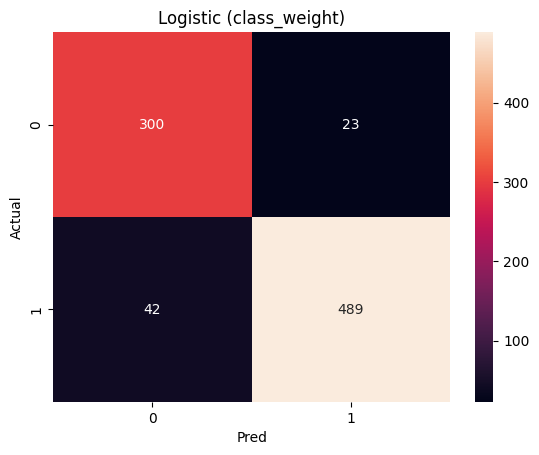


--- DecisionTree (class_weight) ---
              precision    recall  f1-score   support

           0     0.9780    0.9628    0.9704       323
           1     0.9776    0.9868    0.9822       531

    accuracy                         0.9778       854
   macro avg     0.9778    0.9748    0.9763       854
weighted avg     0.9778    0.9778    0.9777       854

Confusion matrix:
 [[311  12]
 [  7 524]]
Precision: 0.9776, Recall: 0.9868, F1: 0.9822
ROC AUC: 0.9748328115069995


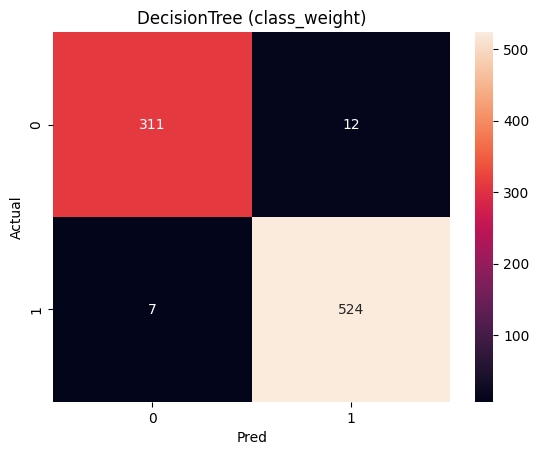

In [14]:
def evaluate(pipe, X_test, y_test, name="model"):
    y_pred = pipe.predict(X_test)
    print(f"\n--- {name} ---")
    print(classification_report(y_test, y_pred, digits=4))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion matrix:\n", cm)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
    if hasattr(pipe.named_steps['clf'], "predict_proba"):
        y_prob = pipe.predict_proba(X_test)[:,1]
        try:
            print("ROC AUC:", roc_auc_score(y_test, y_prob))
        except:
            pass
    sns.heatmap(cm, annot=True, fmt='d'); plt.xlabel('Pred'); plt.ylabel('Actual'); plt.title(name); plt.show()

evaluate(log_pipe, X_test, y_test, "Logistic (class_weight)")



--- DecisionTree (class_weight) ---
              precision    recall  f1-score   support

           0     0.9780    0.9628    0.9704       323
           1     0.9776    0.9868    0.9822       531

    accuracy                         0.9778       854
   macro avg     0.9778    0.9748    0.9763       854
weighted avg     0.9778    0.9778    0.9777       854

Confusion matrix:
 [[311  12]
 [  7 524]]
Precision: 0.9776, Recall: 0.9868, F1: 0.9822
ROC AUC: 0.9748328115069995


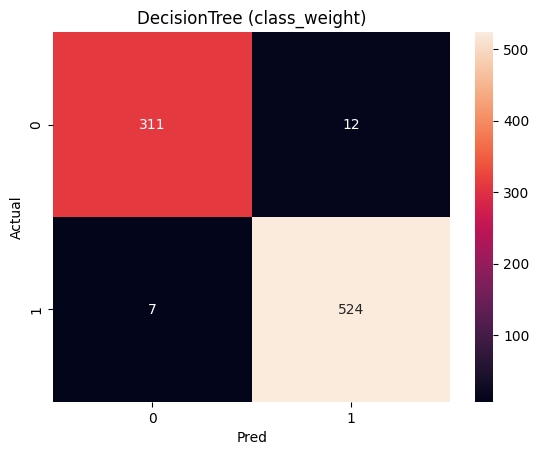

In [15]:
evaluate(dt_pipe, X_test, y_test, "DecisionTree (class_weight)")

#SMOTE resampling
Use SMOTE to oversample minority class in training set only, then train.



--- Logistic + SMOTE ---
              precision    recall  f1-score   support

           0     0.8791    0.9226    0.9003       323
           1     0.9515    0.9228    0.9369       531

    accuracy                         0.9227       854
   macro avg     0.9153    0.9227    0.9186       854
weighted avg     0.9241    0.9227    0.9231       854

Confusion matrix:
 [[298  25]
 [ 41 490]]
Precision: 0.9515, Recall: 0.9228, F1: 0.9369
ROC AUC: 0.9731973669634372


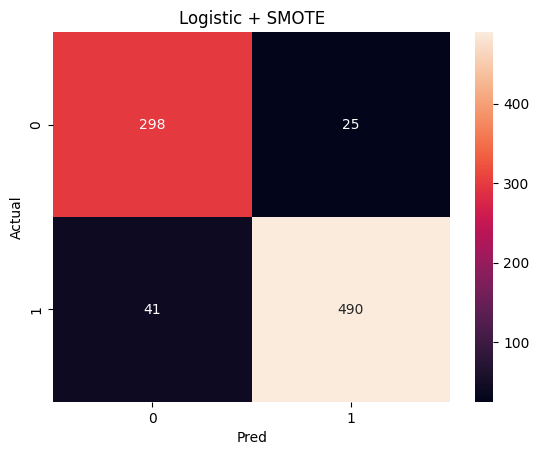


--- DecisionTree + SMOTE ---
              precision    recall  f1-score   support

           0     0.9749    0.9628    0.9688       323
           1     0.9776    0.9849    0.9812       531

    accuracy                         0.9766       854
   macro avg     0.9762    0.9739    0.9750       854
weighted avg     0.9766    0.9766    0.9766       854

Confusion matrix:
 [[311  12]
 [  8 523]]
Precision: 0.9776, Recall: 0.9849, F1: 0.9812
ROC AUC: 0.973891191921312


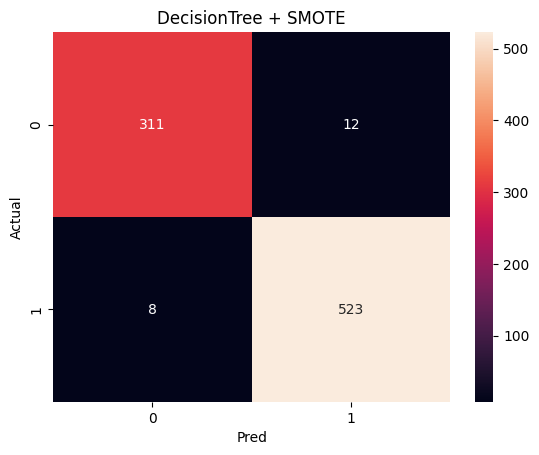

In [16]:
sm = SMOTE(random_state=42)

log_smote_pipe = ImbPipeline([
    ('preproc', preprocessor),
    ('smote', sm),
    ('clf', LogisticRegression(max_iter=1000, solver='liblinear', random_state=42))
])
log_smote_pipe.fit(X_train, y_train)
evaluate(log_smote_pipe, X_test, y_test, "Logistic + SMOTE")

dt_smote_pipe = ImbPipeline([
    ('preproc', preprocessor),
    ('smote', sm),
    ('clf', DecisionTreeClassifier(random_state=42))
])
dt_smote_pipe.fit(X_train, y_train)
evaluate(dt_smote_pipe, X_test, y_test, "DecisionTree + SMOTE")


#Threshold tuning
Find best probability threshold for maximum F1 score.


In [18]:
# get probs on test or better: use validation split inside training set
y_prob = log_smote_pipe.predict_proba(X_test)[:,1]

best_thr, best_f1 = 0.5, 0
for thr in np.linspace(0.1, 0.9, 81):
    y_pred_thr = (y_prob >= thr).astype(int)
    f1 = f1_score(y_test, y_pred_thr)
    if f1 > best_f1:
        best_f1, best_thr = f1, thr

print("Best threshold (test):", best_thr, "Best F1:", best_f1)
# Use that threshold in production when predicting:
# preds = (model.predict_proba(X_new)[:,1] >= best_thr).astype(int)


Best threshold (test): 0.5700000000000001 Best F1: 0.9381044487427466
